# Logistic Regression On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
    9.1 TF-IDF weighted W2V
10. Conclusion<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using Logistic Regression algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words, TF-IDF, avg Word2Vec, TF-IDF weighted Word2Vec. 

In [2]:
# loading required libraries 
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import gensim
import scipy 
import nltk
import time
import seaborn as sns 
from scipy import stats
from matplotlib import pyplot as plt 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as prf1

from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

#Applying dimensionality reduction 
def truncated_svd(data):
    svd = TruncatedSVD(n_components = 100, random_state = 0)
    svd_val = svd.fit_transform(data)
    return svd_val

## 3. Loading the data

In [4]:
#Loading the data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

Loading the pre-processed data using sqlite. This dataset has no entry with score 3 which is previously removed. And the scores which are greater than 3 are denoted as 'positive' and which are less than 3 are denoted as 'negative' scores.

In [5]:
print(data.shape)
data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing

Loaded data is imbalanced and logistic regression is very sensitive to imbalanced data as well as to mismatch between the class distribution of train-set and test-set. So, it is a good idea to upsample or downsample the data to balance the two classes. Here, I'm downsampling my data. 

In [6]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
# sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [8]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [9]:
sorted_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [10]:
score = np.array(sorted_data.Score.reshape(sorted_data.shape[0],1))

In [11]:
score.shape

(364171, 1)

## 5. Function Definitions

### [A.] Data Spliting 

In [12]:
# spliting the data
def data_split(data, score):
    # train data 70% and test data 30%
    train_x, test_x, train_y, test_y = train_test_split(data, score, test_size=0.3, shuffle=False)    
    return train_x, test_x, train_y, test_y

### [B.] Logistic Regression

In [24]:
# applying logistic regression with both L1 and L2 normalization
def logistic_regression(X, Y, vectorizer):
    cv_err_l1 = []
    train_err_l1 = []
    cv_err_l2 = []
    train_err_l2 = []
    w_nonz = []
    penalty = ['l1', 'l2']
    c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=36)
    for train, cv in Kfold.split(X):
        for l in penalty:
            for c in c_val:
                lr_model = LogisticRegression(penalty = l, C = c, class_weight = 'balanced', n_jobs = -1)
                
                vect_model = vectorizer.fit(X.iloc[train]['CleanedText'].values)
                train_vect = vect_model.transform(X.iloc[train]['CleanedText'].values)
                cv_vect = vect_model.transform(X.iloc[cv]['CleanedText'].values)
            
                lr_model.fit(train_vect, Y[train])
                
                if l == 'l1':
                    cv_err_l1.append(1 - (lr_model.score(cv_vect, Y[cv])))
                    train_err_l1.append(1 - (lr_model.score(train_vect, Y[train])))
                    w_nonz.append(np.count_nonzero(lr_model.coef_))
                else :
                    cv_err_l2.append(1 - (lr_model.score(cv_vect, Y[cv])))
                    train_err_l2.append(1 - (lr_model.score(train_vect, Y[train])))
                    
    return cv_err_l1, train_err_l1, cv_err_l2, train_err_l2, w_nonz

In [107]:
# applying logistic regression with both L1 and L2 normalization
def lr_w2v(X, Y):
    cv_err_l1 = []
    train_err_l1 = []
    cv_err_l2 = []
    train_err_l2 = []
    w_nonz = []
    penalty = ['l1', 'l2']
    c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False)
    for train, cv in Kfold.split(X):
        for l in penalty:
            for c in c_val:
                lr_model = LogisticRegression(penalty = l, C = c, class_weight = 'balanced', n_jobs = 8)
                
                w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=8)
                train_vect = avg_w2v(X[train], w2v_model)
                cv_vect = avg_w2v(X[cv], w2v_model)
            
                lr_model.fit(train_vect, Y[train])
                
                if l == 'l1':
                    cv_err_l1.append(1 - (lr_model.score(cv_vect, Y[cv])))
                    train_err_l1.append(1 - (lr_model.score(train_vect, Y[train])))
                    w_nonz.append(np.count_nonzero(lr_model.coef_))
                else :
                    cv_err_l2.append(1 - (lr_model.score(cv_vect, Y[cv])))
                    train_err_l2.append(1 - (lr_model.score(train_vect, Y[train])))
                    
    return cv_err_l1, train_err_l1, cv_err_l2, train_err_l2, w_nonz

### [C.] Error Curve 

In [15]:
# comparing error between cv and test data
def error_comparision(cv_err, train_err):
    sns.set()
    c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(c_val, cv_err[i,:],label = 'cv_error', color = 'r')
        plt.plot(c_val, train_err[i,:],label = 'train_error', color = 'b')
        plt.xscale('log')
        plt.xlabel('C-Values')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TRAIN-ERR for Fold '+str(i+1))

### [D.] Accuracy Metrics 

In [36]:
# test accuracy and ROC plot
def final_test_acc(train_data, train_score, test_data, test_score, l, best_c, name):
    lr_model = LogisticRegression(penalty = l, C = best_c, class_weight = 'balanced', n_jobs = 8)
    lr_model.fit(train_data, train_score)
    
    # Train Metric
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred_trn = lr_model.predict(train_data)
    acc_trn = accuracy_score(train_score, pred_trn, normalize=True) * float(100)
    print("\nTrain accuracy for C = '{0}' is '{1}'".format(best_c, acc_trn))
    ytrn_pred_proba = lr_model.predict_proba(train_data)[::,1]
    fpr0, tpr0, thresholds0 = roc_curve(train_score, ytrn_pred_proba)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr0, tpr0, label='Logistic Regression', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('Logistic Regression ROC curve for '+name+' with C '+str(best_c))
    plt.show()
    print('Area under the ROC curve is ', roc_auc_score(train_score, ytrn_pred_proba))
    conf_matx_trn = confusion_matrix(train_score, pred_trn)
    print('\nConfusion Matrix :\n', conf_matx_trn)
    norm_conf_matx_trn = conf_matx_trn / conf_matx_trn.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx_trn)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx_trn, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision_trn, recall_trn, fscore_trn, support_trn = prf1(train_score, pred_trn)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision_trn[0]*100, precision_trn[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall_trn[0]*100, recall_trn[1]*100))
    print('F1-score   : {}'.format(fscore_trn))
    plt.show()
    
    
    
    # Test Metric
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred = lr_model.predict(test_data)
    acc = accuracy_score(test_score, pred, normalize = True) * float(100)
    print("\nTest accuracy for C = '{0}' is '{1}'".format(best_c, acc))
    
    y_pred_proba = lr_model.predict_proba(test_data)[::,1]
    fpr, tpr, thresholds = roc_curve(test_score, y_pred_proba)
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='Logistic Regression', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('Logistic-Regression ROC curve for '+ name)
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(test_score, y_pred_proba))
    conf_matx = confusion_matrix(test_score,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_score, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

### [E.] Grid Search 

In [17]:
# applying grid search to find best c 
def grid_search_cv(data_trn, score_trn, data_test, score_test, l):
    
    tuned_parameters = [{'C': [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]}]
    
    model = GridSearchCV(LogisticRegression(penalty=l, class_weight = 'balanced', n_jobs = 8), tuned_parameters, scoring = 'f1', cv=3)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [F.] Random Search 

In [18]:
# applying random search to find best c 
def random_search_cv(data_trn, score_trn, data_test, score_test, l):
    
    tuned_parameters={'C': scipy.stats.norm(10)}
    model = RandomizedSearchCV(LogisticRegression(penalty=l, class_weight = 'balanced', n_jobs = 8), tuned_parameters, scoring = 'f1', cv=3)
    model.fit(data_trn, score_trn)
                                                                                   
    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [G.] Multicollinearity Test

In [19]:
# checking the severity of multicollinearity 
def multi_colinearity_test(data, score, c):
    lr = LogisticRegression(penalty = 'l2', C = c, class_weight = 'balanced', random_state = 36, n_jobs = 8)
    lr.fit(data, score)
    coef_before = lr.coef_
    
    # adding small perturbation
    data.data += data.data.min()
    lr = LogisticRegression(penalty = 'l2', C = c, class_weight = 'balanced', random_state = 36, n_jobs = 8)
    lr.fit(data, score)
    coef_after = lr.coef_
    dist = np.linalg.norm(coef_after-coef_before)
    
    # effect of petubation in terms of euclidean distance
    print("Euclidean distance between these two weight vectors is ", dist)
    
    # effect of pertubation in terms of cosine distance 
    cos = np.dot(coef_after, coef_before.T) / (np.linalg.norm(coef_after) * np.linalg.norm(coef_before))
    print("\nCosine similarity between these two weight vectors is ", cos[0,0])
    print("\ni.e the angle between them is ", np.rad2deg(np.arccos(cos))[0,0])

### [H.] Top Features Selection

In [20]:
# finding top features for each class
def top_features(data, score, vectorizer, top_n, c):

    lr = LogisticRegression(penalty = 'l2', C = c, class_weight = 'balanced', random_state = 36, n_jobs = 8)
    lr.fit(data, score)
    
    # sorting the weight indices 
    pos_class_weight_sorted = -lr.coef_.argsort()
    neg_class_weight_sorted = lr.coef_.argsort()
    
    # top negative features
    print('Top '+str(top_n)+' "NEGATIVE" Features are:\n')
    neg = np.take(vectorizer.get_feature_names(), neg_class_weight_sorted[:top_n])
    for i in range(top_n):
        print(neg[0][i])
        
    # top positive features 
    print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
    pos = np.take(vectorizer.get_feature_names(), pos_class_weight_sorted[:top_n])
    for i in range(top_n):
        print(pos[0][i])

## 6. Bag of Words (BoW)

In [21]:
train_x, test_x, train_y, test_y = data_split(sorted_data, score)

In [22]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer(min_df = 0)

In [46]:
# column standardization 
#final_counts = standardizer(final_counts)

I'm skipping the column standardization because without it the logistic regression performs a little bit better on this dataset.<br>
(I've already tested accuracy measures on standardized data, the above code here is only for demonstration purpose)

### [A.] Both L1 and L2 Normalized Logistic Regression

In [25]:
# applying both L1 & L2 normalized logisticr regression
cv_l1_bow, train_l1_bow, cv_l2_bow, train_l2_bow, w_nonz = logistic_regression(train_x, train_y, count_vect)

In [26]:
# reshaping the cv and test error over 3-Fold cv 
cv_l1_bow = np.reshape(cv_l1_bow,(3, 17))
train_l1_bow = np.reshape(train_l1_bow,(3, 17))
cv_l2_bow = np.reshape(cv_l2_bow,(3, 17))
train_l2_bow = np.reshape(train_l2_bow,(3, 17))

In [27]:
# effect of λ on sparsity of weight vector in L1 normalization 
c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
print("Number of non-zero weights for different values of C(1/λ) are:\n")
for i in range(len(c_val)):
    print("C = {:10.4f}      λ = {:10.4f}      nonzero_w = {:9.0f}".format(c_val[i],1/c_val[i],np.reshape(w_nonz,(3,17))[0,:][i]))

Number of non-zero weights for different values of C(1/λ) are:

C =     0.0001      λ = 10000.0000      nonzero_w =         2
C =     0.0005      λ =  2000.0000      nonzero_w =        23
C =     0.0010      λ =  1000.0000      nonzero_w =        61
C =     0.0050      λ =   200.0000      nonzero_w =       264
C =     0.0100      λ =   100.0000      nonzero_w =       440
C =     0.0500      λ =    20.0000      nonzero_w =      1274
C =     0.1000      λ =    10.0000      nonzero_w =      2035
C =     0.5000      λ =     2.0000      nonzero_w =      5744
C =     1.0000      λ =     1.0000      nonzero_w =      8369
C =     5.0000      λ =     0.2000      nonzero_w =     15829
C =    10.0000      λ =     0.1000      nonzero_w =     18389
C =    50.0000      λ =     0.0200      nonzero_w =     22883
C =   100.0000      λ =     0.0100      nonzero_w =     24402
C =   500.0000      λ =     0.0020      nonzero_w =     27329
C =  1000.0000      λ =     0.0010      nonzero_w =     28417
C =  5

#### Observation:
* We can see here as the λ value increases the non-zero weights count decreases i.e the weight vector becomes more sparse in case of L1 normalized Logistic Regression.

### [B.] Error Plot Over Different Values of Hyperparameter C (1 / λ)

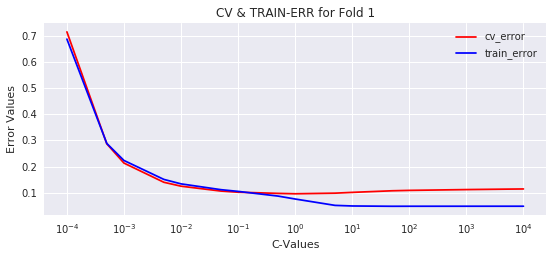

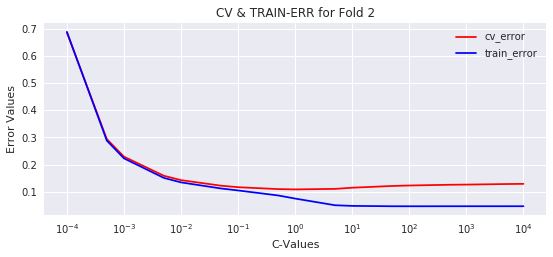

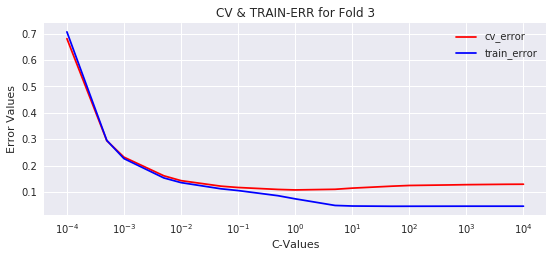

In [28]:
# cv error and test error for L1 normalization 
error_comparision(cv_l1_bow, train_l1_bow)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value ranging from 0.1 to 1.
* Other than that we can observe here, for low C(i.e high λ) we are getting high error because of underfitting and for high C(i.e low λ) we are also getting error value rising becasue it overfits the model.

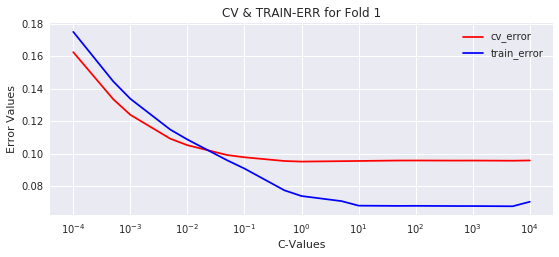

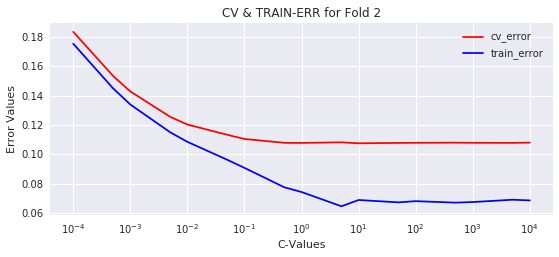

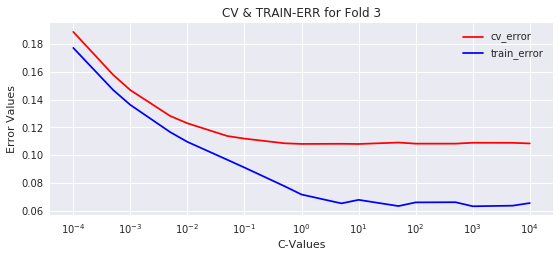

In [29]:
# cv error and test error for L2 normalization 
error_comparision(cv_l2_bow, train_l2_bow)

#### Observation:
* From these error plots for L2-Logistic Regression we get optimal error for C-value near around 0.1.
* Other than that we can observe here, for low C(i.e high λ) we are getting high error because of underfitting and for high C(i.e low λ) we are also getting error value rising becasue it overfits the model.

In [30]:
bow_model = count_vect.fit(train_x['CleanedText'].values)
final_counts_train = bow_model.transform(train_x['CleanedText'].values)
final_counts_test = bow_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [31]:
# finding best fit c using grid search (for L1)
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l1')

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9315155139499046


In [32]:
# finding best fit c using grid search (for L2)
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l2')

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9319617978690985


#### Observation:
* From grid-search we are getting optimal C equal to 0.5 for L1 Logistic Regression and the accuracy is 88.3%.
* From grid-search we are getting optimal C equal to 0.1 for L2 Logistic Regression and the accuracy is nearly same to the L1 accuracy score.

### [D.] Random Search 

In [33]:
# finding best fit c using random search (for L1) 
random_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l1')

LogisticRegression(C=9.038735980006326, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9272898853270038


In [34]:
# finding best fit c using random search (for L2) 
random_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l2')

LogisticRegression(C=7.776004739444883, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9311323247291817


#### Observation:
* From random-search we are getting optimal C equal to 9.7 for L1 Logistic Regression with accuracy equal to 86%.
* From random-search we are getting optimal C equal to 9.5 for L2 Logistic Regression with accuracy 87.2%.
* Overally, grid-search performed better here.

### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for C = '1.0' is '92.09121328735795'


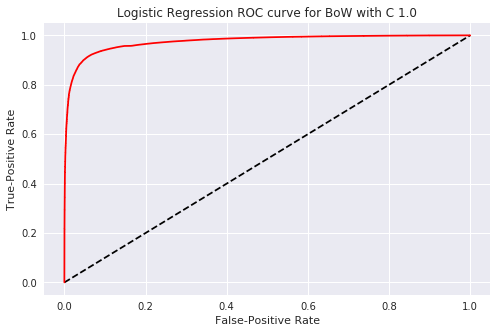

Area under the ROC curve is  0.9749299843523785

Confusion Matrix :
 [[ 35658   2371]
 [ 17790 199100]]

Normalized Confusion Matrix :
 [[0.93765284 0.06234716]
 [0.08202315 0.91797685]]

Precision  : 66.72%, 98.82%
Recall     : 93.77%, 91.80%
F1-score   : [0.7796058  0.95180956]


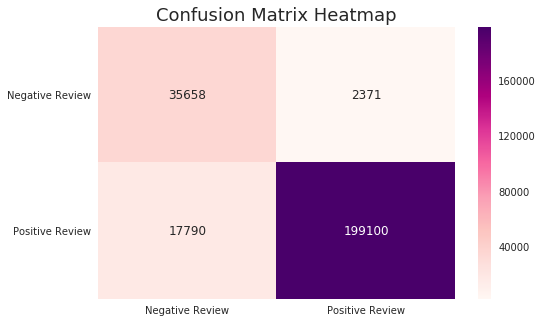

				ACCURACY METRIC FOR TRAIN-SET


Test accuracy for C = '1.0' is '89.10225899754695'


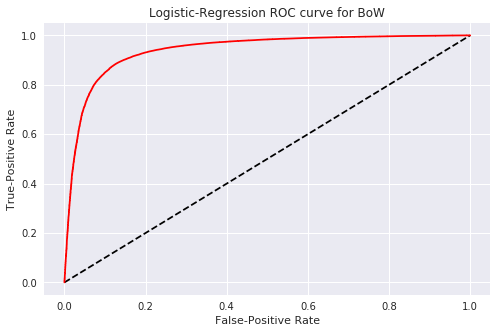

Area under the ROC curve is  0.9390768316479922

Confusion Matrix :
 [[16341  2740]
 [ 9166 81005]]

Normalized Confusion Matrix :
 [[0.85640166 0.14359834]
 [0.10165131 0.89834869]]

Precision  : 64.06%, 96.73%
Recall     : 85.64%, 89.83%
F1-score   : [0.73297748 0.93154166]


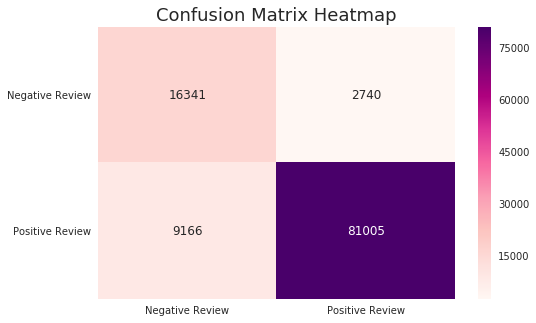

In [38]:
# accuracy measures for L1
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 'l1', 1.0, 'BoW')

#### Observation:
* For L1 Logistic regression I choosed C to be 0.5 from grid-search and we got here accuracy equal to 88.35% for test-set.
* Area under the ROC curve is algo high(i.e 0.94) and false positive and false negative rates are also pretty low which is a good sign.

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for C = '1.0' is '92.3866012341175'


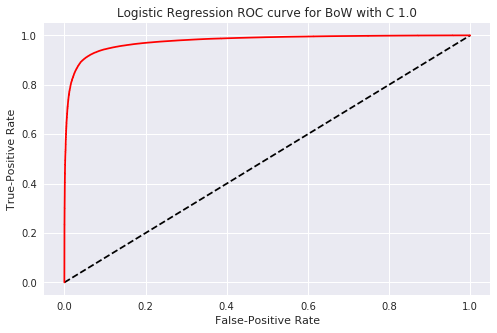

Area under the ROC curve is  0.9763080239592494

Confusion Matrix :
 [[ 35584   2445]
 [ 16963 199927]]

Normalized Confusion Matrix :
 [[0.93570696 0.06429304]
 [0.07821015 0.92178985]]

Precision  : 67.72%, 98.79%
Recall     : 93.57%, 92.18%
F1-score   : [0.7857269  0.95370914]


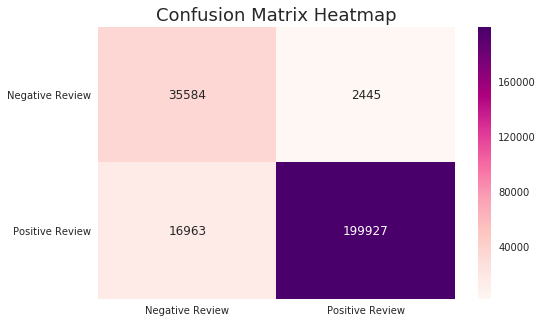

				ACCURACY METRIC FOR TRAIN-SET


Test accuracy for C = '1.0' is '89.16907699630214'


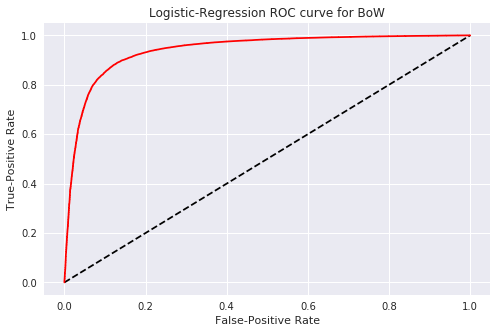

Area under the ROC curve is  0.9400033146671414

Confusion Matrix :
 [[16377  2704]
 [ 9129 81042]]

Normalized Confusion Matrix :
 [[0.85828835 0.14171165]
 [0.10124098 0.89875902]]

Precision  : 64.21%, 96.77%
Recall     : 85.83%, 89.88%
F1-score   : [0.73460874 0.9319618 ]


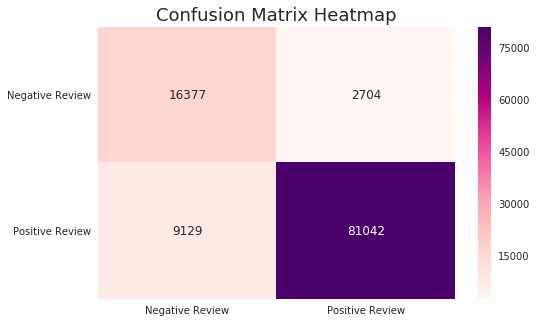

In [41]:
# accuracy measures for L2
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 'l2', 1.0, 'BoW')

#### Observation:
* For L2 Logistic regression I choosed C to be 0.1 from grid-search and we got here accuracy equal to 88.37% for test-set.
* Area under the ROC curve is algo high(i.e 0.94) and false positive and false negative rates are also pretty low which is a good sign.
* So both L1 and L2 produced nearly same results.

### [F.] Multicollinearity Test

In [42]:
# multicollinearity severity testing 
multi_colinearity_test(final_counts_train, train_y, 1.0)

Euclidean distance between these two weight vectors is  32.6105360660923

Cosine similarity between these two weight vectors is  0.9443136842075925

i.e the angle between them is  19.210918293397967


#### Observation:
* After small perturbation I got new weight vector which is 7.95 unit away from the previous weight vector. The euclidean distance is pretty good i.e there no drastic change in weight vector due to perturbation.
* Also the Cosine similarity between them is also high i.e small angle(22 degree) between these two vectors.
* So, there is no major change in the weight vector due to perturbation. Hence, multicollinearity is low.
* That means we can use weight values to predict the feature(word) importance in our corpus.

### [G.] Top Features from Each Class

In [43]:
# printing top features(i.e words here) for each class
top_features(final_counts_train, train_y, count_vect, 10, 1.0)

Top 10 "NEGATIVE" Features are:

mope
sonewher
patchwork
allrecip
yadayadayada
mozzerela
vagan
hadni
gind
grainiest

Top 10 "POSITIVE" Features are:

immediatl
configuraion
geriatrx
wol
afterschool
ibezan
bagh
oder
parallel
oust


### 6.1 Bag of Words (Bi-Gram)

In [44]:
#Adding both uni-gram and bi-gram to BoW
count_vect = CountVectorizer(ngram_range=(1,2), min_df = 0)

In [60]:
# column standardization 
#final_bigram_counts = standardizer(final_bigram_counts)

I'm skipping the column standardization because without it the logistic regression performs a little bit better on this dataset.<br>
(I've already tested accuracy measures on standardized data, the above code here is only for demonstration purpose)

### [A.] Both L1 and L2 Normalized Logistic Regression

In [45]:
# applying both L1 and L2 regularized logistic regression 
cv_l1_bigram, train_l1_bigram, cv_l2_bigram, train_l2_bigram, w_nonz  = logistic_regression(train_x, train_y, count_vect)

In [46]:
# reshaping the cv error and test error over 3-Fold cv
cv_l1_bi = np.reshape(cv_l1_bigram,(3, 17))
train_l1_bi = np.reshape(train_l1_bigram,(3, 17))
cv_l2_bi = np.reshape(cv_l2_bigram,(3, 17))
train_l2_bi = np.reshape(train_l2_bigram,(3, 17))

In [47]:
# effect of λ on sparsity of weight vector in L1 normalization 
c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
print("Number of non-zero weights for different values of C(1/λ) are:\n")
for i in range(len(c_val)):
    print("C = {:10.4f}      λ = {:10.4f}      nonzero_w = {:9.0f}".format(c_val[i],1/c_val[i],np.reshape(w_nonz,(3,17))[0,:][i]))

Number of non-zero weights for different values of C(1/λ) are:

C =     0.0001      λ = 10000.0000      nonzero_w =         2
C =     0.0005      λ =  2000.0000      nonzero_w =        23
C =     0.0010      λ =  1000.0000      nonzero_w =        63
C =     0.0050      λ =   200.0000      nonzero_w =       273
C =     0.0100      λ =   100.0000      nonzero_w =       463
C =     0.0500      λ =    20.0000      nonzero_w =      1528
C =     0.1000      λ =    10.0000      nonzero_w =      2813
C =     0.5000      λ =     2.0000      nonzero_w =     11866
C =     1.0000      λ =     1.0000      nonzero_w =     17494
C =     5.0000      λ =     0.2000      nonzero_w =     24808
C =    10.0000      λ =     0.1000      nonzero_w =     26657
C =    50.0000      λ =     0.0200      nonzero_w =     30639
C =   100.0000      λ =     0.0100      nonzero_w =     33465
C =   500.0000      λ =     0.0020      nonzero_w =     50089
C =  1000.0000      λ =     0.0010      nonzero_w =     63818
C =  5

#### Observation:
* We can see here as the λ value increases the non-zero weights count decreases i.e the weight vector becomes more sparse in case of L1 normalized Logistic Regression.

### [B.] Error Plot Over Different Values of Hyperparameter C (1 / λ)

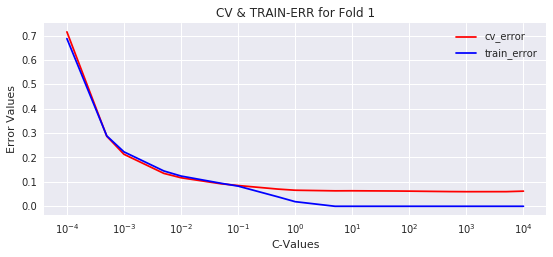

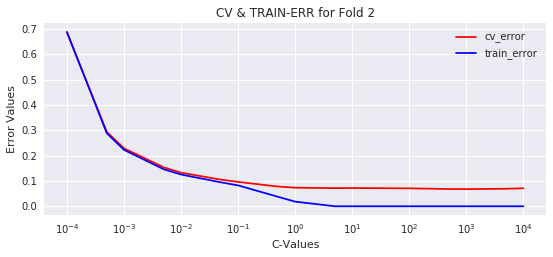

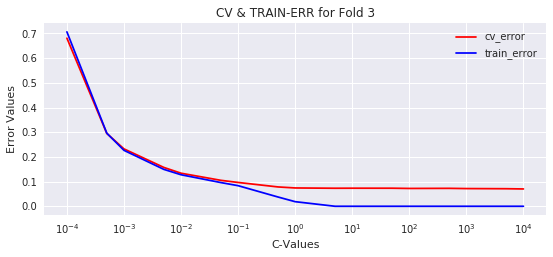

In [48]:
# cv error and test error for L1 regularization 
error_comparision(cv_l1_bi, train_l1_bi)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value near to 1.
* Other than that we can observe here, for low C(i.e high λ) we are getting high error because of underfitting and for high C(i.e low λ) we are also getting error value little rising becasue it overfits the model.

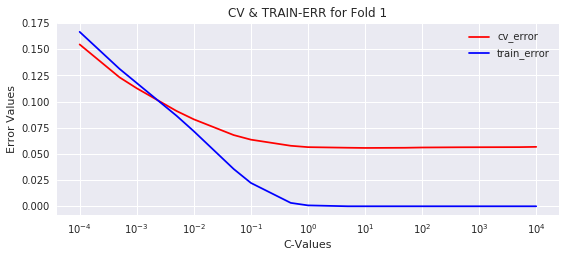

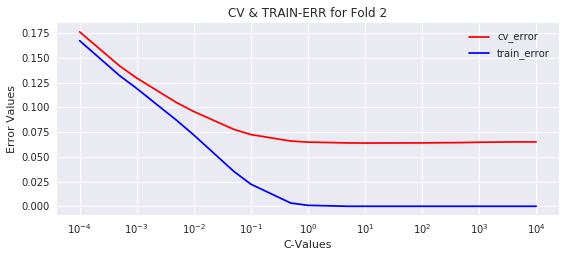

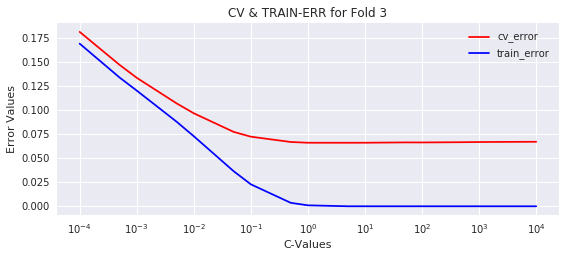

In [49]:
# cv error and test error for L2 regularization 
error_comparision(cv_l2_bi, train_l2_bi)

#### Observation:
* From these error plots for L2-Logistic Regression we get optimal error for C-value ranging from 0.1 to 1.
* Other than that we can observe here, for low C(i.e high λ) we are getting high error because of underfitting and for high C(i.e low λ) we are also getting error value little rising becasue it overfits the model.

In [50]:
bi_model = count_vect.fit(train_x['CleanedText'].values)
final_counts_train = bi_model.transform(train_x['CleanedText'].values)
final_counts_test = bi_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [51]:
# finding best fit c using grid search (for L1)
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l1')

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9574500954503823


In [52]:
# finding best fit c using grid search (for L2)
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l2')

LogisticRegression(C=10.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9612165363920196


#### Observation:
* From grid-search we are getting optimal C equal to 0.5 for L1 Logistic Regression and the accuracy is 90.2%.
* From grid-search we are getting optimal C equal to 0.5 for L2 Logistic Regression and the accuracy is nearly same(90.6%) to the L1 accuracy score.

### [D.] Random Search 

In [53]:
# finding best fit c using random search (for L1)
random_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l1')

LogisticRegression(C=9.697769592215455, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9574003216325626


In [54]:
# finding best fit c using random search (for L2)
random_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l2')

LogisticRegression(C=10.334907830148143, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.961190791185311


#### Observation:
* From random-search we are getting optimal C equal to 10.7 for L1 Logistic Regression with accuracy equal to 89.4%.
* From random-search we are getting optimal C equal to 9.4 for L2 Logistic Regression with accuracy 90.5%.
* Overally, grid-search performed better here.

### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for C = '9.7' is '99.9976463111812'


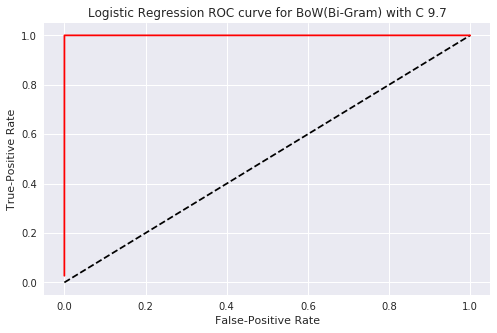

Area under the ROC curve is  0.9999999978176818

Confusion Matrix :
 [[ 38029      0]
 [     6 216884]]

Normalized Confusion Matrix :
 [[1.00000000e+00 0.00000000e+00]
 [2.76637927e-05 9.99972336e-01]]

Precision  : 99.98%, 100.00%
Recall     : 100.00%, 100.00%
F1-score   : [0.99992112 0.99998617]


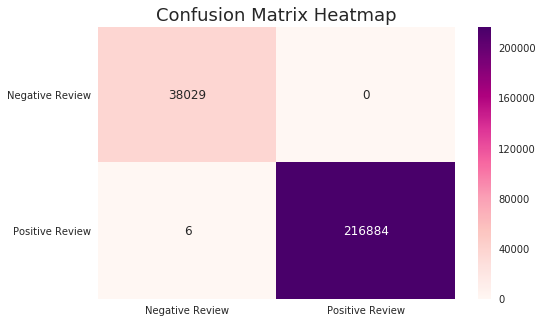

				ACCURACY METRIC FOR TRAIN-SET


Test accuracy for C = '9.7' is '92.95939662431809'


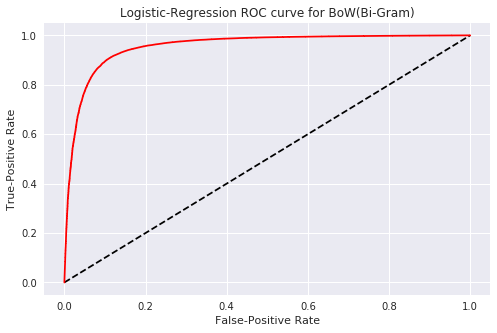

Area under the ROC curve is  0.955103735142397

Confusion Matrix :
 [[15239  3842]
 [ 3850 86321]]

Normalized Confusion Matrix :
 [[0.79864787 0.20135213]
 [0.04269665 0.95730335]]

Precision  : 79.83%, 95.74%
Recall     : 79.86%, 95.73%
F1-score   : [0.79848048 0.95734581]


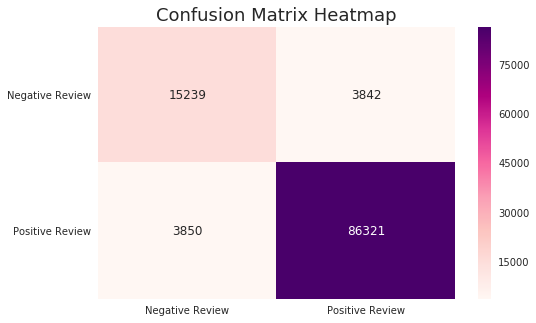

In [56]:
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 'l1', 9.7, 'BoW(Bi-Gram)')

#### Observation:
* For L1 Logistic regression I choosed C to be 0.5 from grid-search and we got here accuracy equal to 90.2% for test-set.
* Area under the ROC curve is algo high(i.e 0.96) and false positive and false negative rates are also pretty low which is a good sign.

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for C = '10.335' is '99.9976463111812'


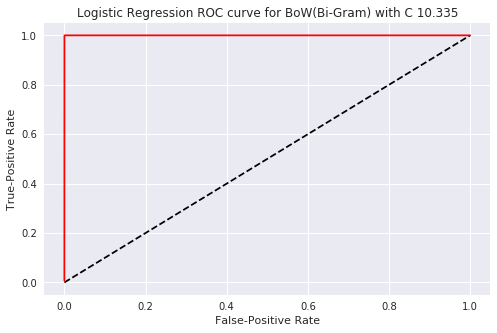

Area under the ROC curve is  0.9999999974539622

Confusion Matrix :
 [[ 38029      0]
 [     6 216884]]

Normalized Confusion Matrix :
 [[1.00000000e+00 0.00000000e+00]
 [2.76637927e-05 9.99972336e-01]]

Precision  : 99.98%, 100.00%
Recall     : 100.00%, 100.00%
F1-score   : [0.99992112 0.99998617]


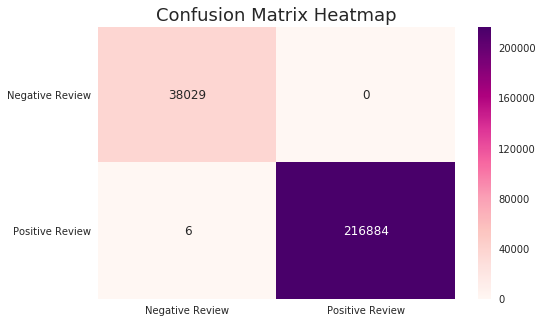

				ACCURACY METRIC FOR TRAIN-SET


Test accuracy for C = '10.335' is '93.58547211950354'


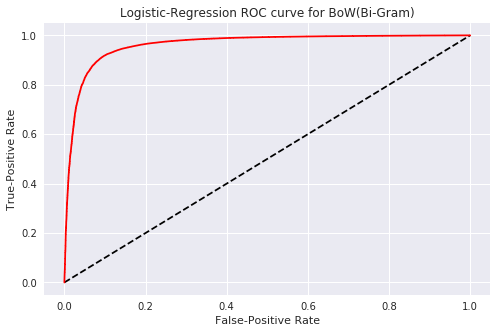

Area under the ROC curve is  0.962306383693877

Confusion Matrix :
 [[15423  3658]
 [ 3350 86821]]

Normalized Confusion Matrix :
 [[0.80829097 0.19170903]
 [0.03715163 0.96284837]]

Precision  : 82.16%, 95.96%
Recall     : 80.83%, 96.28%
F1-score   : [0.81486765 0.96120675]


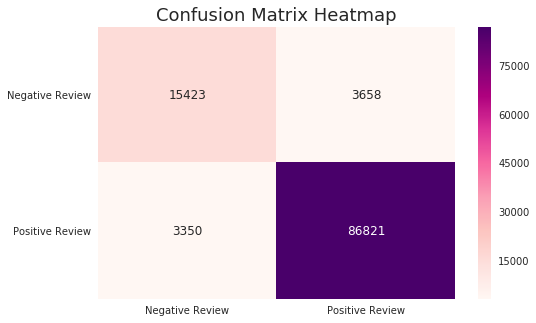

In [58]:
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 'l2', 10.335, 'BoW(Bi-Gram)')

#### Observation:
* For L2 Logistic regression I choosed C to be 0.5 from grid-search and we got here accuracy equal to 90.6% for test-set.
* Area under the ROC curve is algo high(i.e 0.96) and false positive and false negative rates are also pretty low which is a good sign.

### [F.] Multicollinearity Test

In [61]:
# multicollinearity severity testing 
multi_colinearity_test(final_counts_train, train_y, count_vect, 10.335)

Euclidean distance between these two weight vectors is  78.98967763476415

Cosine similarity between these two weight vectors is  0.9935140462284642

i.e the angle between them is  6.529193939265072


#### Observation:
* After small perturbation I got new weight vector which is 16.4 unit away from the previous weight vector. The euclidean distance is reasonable i.e there no drastic change in weight vector due to perturbation.
* Also the Cosine similarity between them is also high(0.98) i.e small angle(9.6 degree) between these two vectors.
* So, there is no major change in the weight vector due to perturbation. Hence, multicollinearity is low.
* That means we can use weight values to predict the feature(word) importance in our corpus.

### [G.] Top Features from Each Class

In [62]:
# printing top features(i.e words here) for each class
top_features(final_counts_train, train_y, count_vect, 10, 10.335)

Top 10 "NEGATIVE" Features are:

two star
not worth
worst
not impress
not sam
not happi
not recommend
dont recommend
least favorit
undrink

Top 10 "POSITIVE" Features are:

beer fantasi
heartburn tend
age week
heavi run
heat prepar
heavier commerci
heat sure
rubberi usual
love concept
beaba allow


## 7. TF-IDF

In [63]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 0)

In [79]:
#final_tf_idf = standardizer(final_tf_idf)

I'm skipping the column standardization because without it the logistic regression performs a little bit better on this dataset.<br>
(I've already tested accuracy measures on standardized data, the above code here is only for demonstration purpose)

### [A.] Both L1 and L2 Normalized Logistic Regression

In [64]:
# applying both L1 & L2 Logistic Regression
cv_l1_tfidf, train_l1_tfidf, cv_l2_tfidf, train_l2_tfidf, w_nonz = logistic_regression(train_x, train_y, tf_idf_vect)

In [65]:
cv_l1_tf = np.reshape(cv_l1_tfidf,(3, 17))
train_l1_tf = np.reshape(train_l1_tfidf,(3, 17))
cv_l2_tf = np.reshape(cv_l2_tfidf,(3, 17))
train_l2_tf = np.reshape(train_l2_tfidf,(3, 17))

In [66]:
# checking sparsity over different C
c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
print("Number of non-zero weights for different values of C(1/λ) are:\n")
for i in range(len(c_val)):
    print("C = {:10.4f}      λ = {:10.4f}      nonzero_w = {:9.0f}".format(c_val[i],1/c_val[i],np.reshape(w_nonz,(3,17))[0,:][i]))

Number of non-zero weights for different values of C(1/λ) are:

C =     0.0001      λ = 10000.0000      nonzero_w =         0
C =     0.0005      λ =  2000.0000      nonzero_w =         0
C =     0.0010      λ =  1000.0000      nonzero_w =         0
C =     0.0050      λ =   200.0000      nonzero_w =         7
C =     0.0100      λ =   100.0000      nonzero_w =        29
C =     0.0500      λ =    20.0000      nonzero_w =       200
C =     0.1000      λ =    10.0000      nonzero_w =       379
C =     0.5000      λ =     2.0000      nonzero_w =      1477
C =     1.0000      λ =     1.0000      nonzero_w =      3129
C =     5.0000      λ =     0.2000      nonzero_w =     15978
C =    10.0000      λ =     0.1000      nonzero_w =     22219
C =    50.0000      λ =     0.0200      nonzero_w =     28571
C =   100.0000      λ =     0.0100      nonzero_w =     29906
C =   500.0000      λ =     0.0020      nonzero_w =     34405
C =  1000.0000      λ =     0.0010      nonzero_w =     38550
C =  5

#### Observation:
* We can see here as the λ value increases the non-zero weights count decreases i.e the weight vector becomes more sparse in case of L1 normalized Logistic Regression.

### [B.] Error Plot Over Different Values of Hyperparameter C (1 / λ)

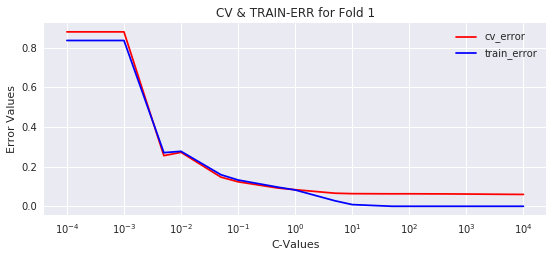

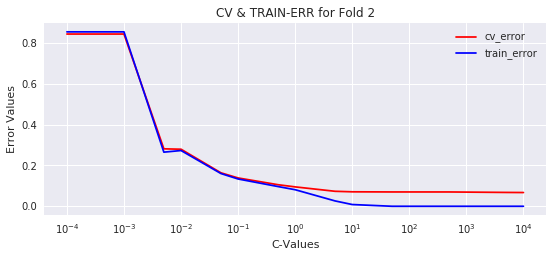

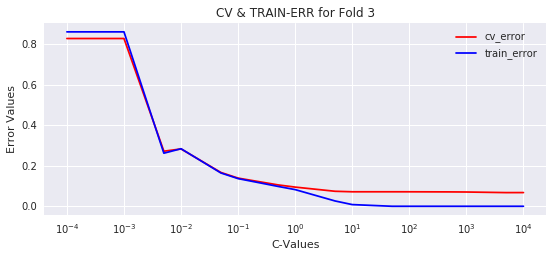

In [67]:
# cv error and test error for L1 regularization 
error_comparision(cv_l1_tf, train_l1_tf)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value near to 10.
* Other than that we can observe here, for low C(i.e high λ) we are getting high error because of underfitting and for high C(i.e low λ) we are also getting error value little rising becasue it overfits the model.

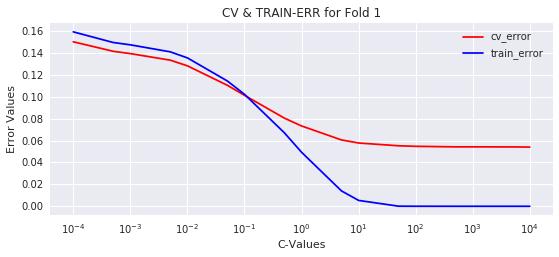

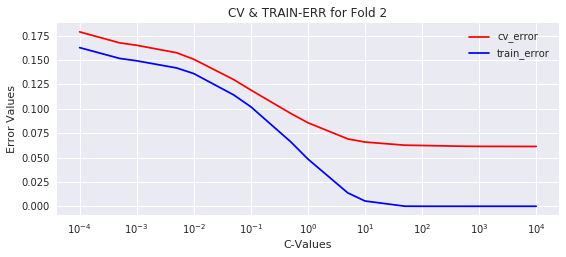

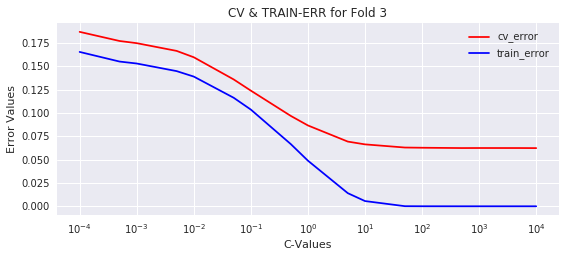

In [68]:
# cv error and test error for L2 regularization 
error_comparision(cv_l2_tf, train_l2_tf)

#### Observation:
* From these error plots for L2-Logistic Regression we get optimal error for C-value ranging between 10 to 10000.

In [69]:
tfidf_model = tf_idf_vect.fit(train_x['CleanedText'].values)
final_counts_train = tfidf_model.transform(train_x['CleanedText'].values)
final_counts_test = tfidf_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [70]:
# finding best fit λ using grid search(L1)
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l1')

LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9598895477397991


In [71]:
# finding best fit λ using grid search(L2)
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l2')

LogisticRegression(C=5000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9630626951982607


#### Observation:
* From grid-search we are getting optimal C equal to 5 for L1 Logistic Regression and the accuracy is 90.4%.
* From grid-search we are getting optimal C equal to 10000 for L2 Logistic Regression and the accuracy is nearly same(90.8%) to the L1 accuracy score.

### [D.] Random Search 

In [72]:
# finding best fit λ using random search(L1)
random_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l1')

LogisticRegression(C=10.061203494615594, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9577371940625367


In [73]:
# finding best fit λ using random search(L2)
random_search_cv(final_counts_train, train_y, final_counts_test, test_y, 'l2')

LogisticRegression(C=12.295921056270508, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9608998393144083


#### Observation:
* From random-search we are getting optimal C equal to 8.3 for L1 Logistic Regression and the accuracy is 90.1%.
* From random-search we are getting optimal C equal to 11 for L2 Logistic Regression and the accuracy is nearly same(90.7%) to the L1 accuracy score.

### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for C = '10' is '99.20053036454716'


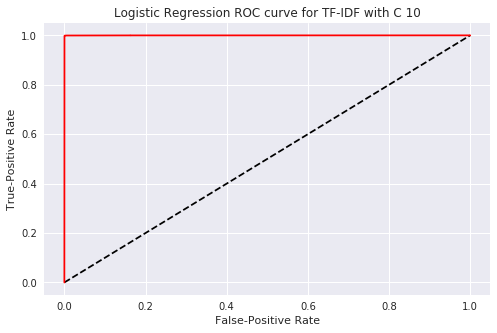

Area under the ROC curve is  0.9999264940678572

Confusion Matrix :
 [[ 38029      0]
 [  2038 214852]]

Normalized Confusion Matrix :
 [[1.         0.        ]
 [0.00939647 0.99060353]]

Precision  : 94.91%, 100.00%
Recall     : 100.00%, 99.06%
F1-score   : [0.97390391 0.99527959]


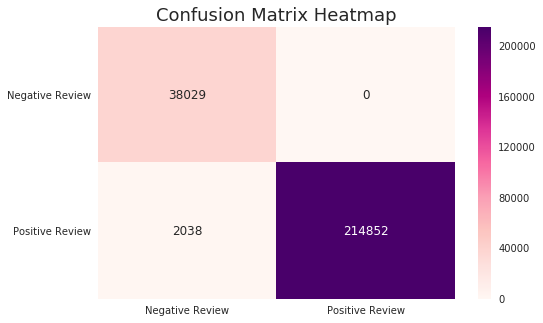

				ACCURACY METRIC FOR TRAIN-SET


Test accuracy for C = '10' is '93.0719803756453'


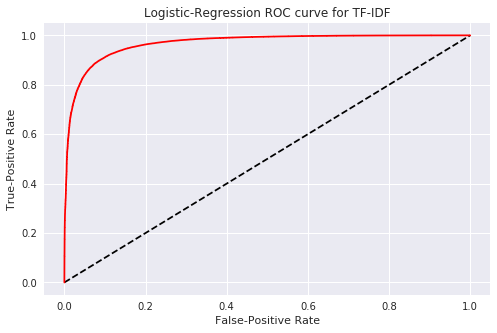

Area under the ROC curve is  0.967343419315865

Confusion Matrix :
 [[15971  3110]
 [ 4459 85712]]

Normalized Confusion Matrix :
 [[0.83701064 0.16298936]
 [0.04945049 0.95054951]]

Precision  : 78.17%, 96.50%
Recall     : 83.70%, 95.05%
F1-score   : [0.80843309 0.95771343]


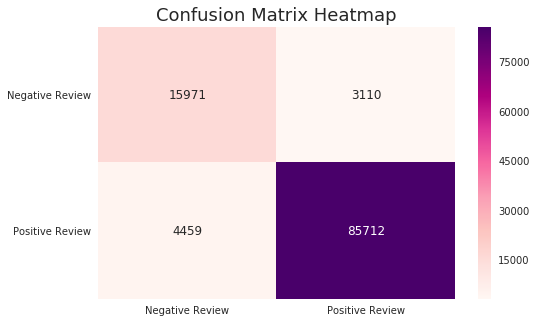

In [75]:
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 'l1', 10, 'TF-IDF')

#### Observation:
* For L1 Logistic regression I choosed C to be 5 from grid-search and we got here accuracy equal to 90.4% for test-set.
* Area under the ROC curve is algo high(i.e 0.97) and false positive and false negative rates are also pretty low which is a good sign.

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for C = '12.3' is '99.54848402825995'


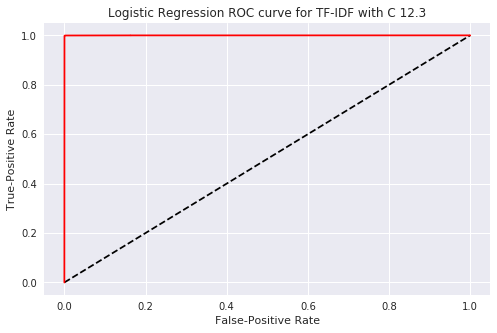

Area under the ROC curve is  0.9999292671880662

Confusion Matrix :
 [[ 38028      1]
 [  1150 215740]]

Normalized Confusion Matrix :
 [[9.99973704e-01 2.62957217e-05]
 [5.30222694e-03 9.94697773e-01]]

Precision  : 97.06%, 100.00%
Recall     : 100.00%, 99.47%
F1-score   : [0.98509203 0.99733953]


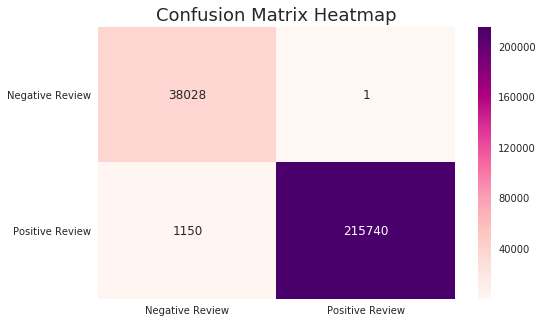

				ACCURACY METRIC FOR TRAIN-SET


Test accuracy for C = '12.3' is '93.58547211950354'


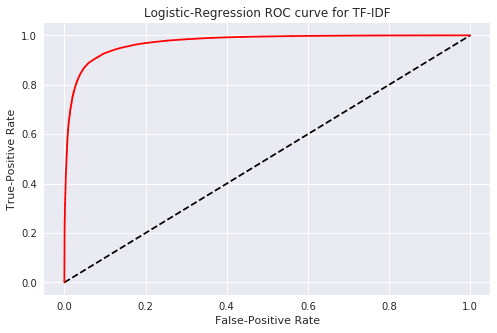

Area under the ROC curve is  0.9720279385942558

Confusion Matrix :
 [[16132  2949]
 [ 4059 86112]]

Normalized Confusion Matrix :
 [[0.84544835 0.15455165]
 [0.04501447 0.95498553]]

Precision  : 79.90%, 96.69%
Recall     : 84.54%, 95.50%
F1-score   : [0.82155225 0.96089984]


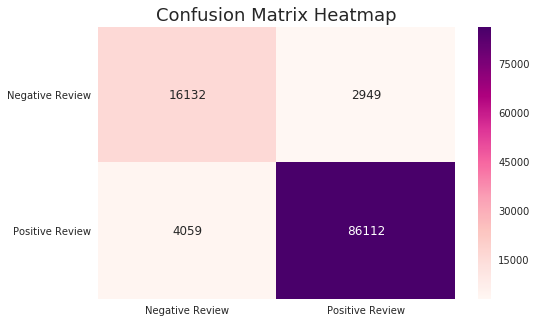

In [77]:
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 'l2', 12.3, 'TF-IDF')

#### Observation:
* For L2 Logistic regression I choosed C to be 11 from random-search and we got here accuracy equal to 90.8% for test-set.
* Area under the ROC curve is algo high(i.e 0.97) and false positive and false negative rates are also pretty low which is a good sign.

### [F.] Multicollinearity Test

In [78]:
# multicollinearity severity testing 
multi_colinearity_test(final_counts_train, train_y, 12.3)

Euclidean distance between these two weight vectors is  8.132986556730057

Cosine similarity between these two weight vectors is  0.9999139439902154

i.e the angle between them is  0.7516771479155147


#### Observation:
* After small perturbation I got new weight vector which is 4.8 unit away from the previous weight vector. The euclidean distance is nearly close i.e there no drastic change in weight vector due to perturbation.
* Also the Cosine similarity between them is also very high(0.99) i.e very small angle(0.7 degree) between these two vectors.
* So, there is no major change in the weight vector due to perturbation. Hence, multicollinearity is very low.
* That means we can use weight values to predict the feature(word) importance in our corpus.

### [G.] Top Features from Each Class

In [79]:
# printing top features(i.e words here) for each class
top_features(final_counts_train, train_y, tf_idf_vect, 10, 12.3)

Top 10 "NEGATIVE" Features are:

disappoint
worst
not worth
two star
aw
not recommend
terribl
not good
horribl
not buy

Top 10 "POSITIVE" Features are:

sauc leak
age week
heartburn tend
beer fantasi
vego
heat sure
butter scorch
heavili artifici
need arctic
held shipment


## 8. Word2Vec

In [86]:
#Importing Libraries 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [81]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [83]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [84]:
print(sorted_data['Text'].values[0])
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


In [85]:
len(list_of_sent)

364171

In [116]:
# creating own model
import gensim
#w2v_model = gensim.models.Word2Vec(list_of_sent, min_count=5, size=100, workers=8)

In [26]:
words = list(w2v_model.wv.vocab)
print(len(words))

20878


## 9. Avg Word2Vec & TF-IDF Word2Vec

In [106]:
#Determining average Word2Vec for each review
def avg_w2v(data, model):
    sent_vectors = []
    for sent in data: 
        sent_vec = np.zeros(100) 
        cnt_words =0; 
        for word in sent: # for each word in a review/sentence
            try:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)

In [ ]:
#stnd_avg_word2vec = standardizer(avg_word2vec)
#stnd_avg_word2vec.shape

### [A.] Both L1 and L2 Normalized Logistic Regression

In [88]:
train_x, test_x, train_y, test_y = data_split(list_of_sent, score)

In [105]:
np.array(train_x).shape

(254919,)

In [108]:
# applying both L1 & L2 Logistic Regression
cv_l1_w2v, train_l1_w2v, cv_l2_w2v, train_l2_w2v, w_nonz = lr_w2v(np.array(train_x), np.array(train_y))

In [109]:
cv_l1_wv = np.reshape(cv_l1_w2v,(3, 17))
train_l1_wv = np.reshape(train_l1_w2v,(3, 17))
cv_l2_wv = np.reshape(cv_l2_w2v,(3, 17))
train_l2_wv = np.reshape(train_l2_w2v,(3, 17))

In [110]:
# checking sparsity over different C for L1
c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
print("Number of non-zero weights for different values of C(1/λ) are:\n")
for i in range(len(c_val)):
    print("C = {:10.4f}      λ = {:10.4f}      nonzero_w = {:9.0f}".format(c_val[i],1/c_val[i],np.reshape(w_nonz,(3,17))[0,:][i]))

Number of non-zero weights for different values of C(1/λ) are:

C =     0.0001      λ = 10000.0000      nonzero_w =         0
C =     0.0005      λ =  2000.0000      nonzero_w =        17
C =     0.0010      λ =  1000.0000      nonzero_w =        30
C =     0.0050      λ =   200.0000      nonzero_w =        69
C =     0.0100      λ =   100.0000      nonzero_w =        81
C =     0.0500      λ =    20.0000      nonzero_w =        97
C =     0.1000      λ =    10.0000      nonzero_w =        96
C =     0.5000      λ =     2.0000      nonzero_w =       100
C =     1.0000      λ =     1.0000      nonzero_w =       100
C =     5.0000      λ =     0.2000      nonzero_w =       100
C =    10.0000      λ =     0.1000      nonzero_w =       100
C =    50.0000      λ =     0.0200      nonzero_w =       100
C =   100.0000      λ =     0.0100      nonzero_w =       100
C =   500.0000      λ =     0.0020      nonzero_w =       100
C =  1000.0000      λ =     0.0010      nonzero_w =       100
C =  5

#### Observation:
* We can see here as the λ value increases the non-zero weights count decreases i.e the weight vector becomes more sparse in case of L1 normalized Logistic Regression.

### [B.] Error Plot Over Different Values of Hyperparameter C (1 / λ)

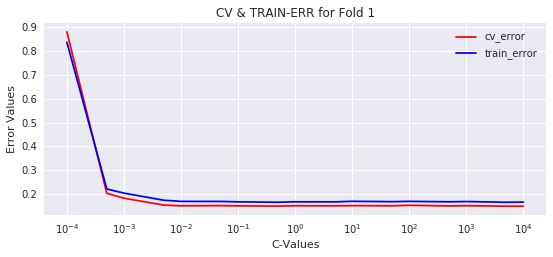

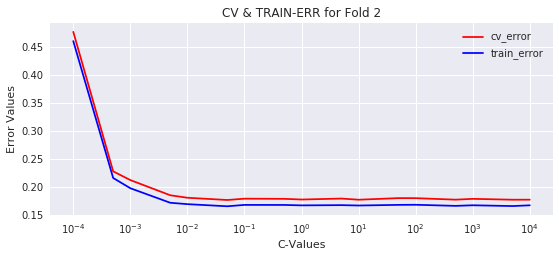

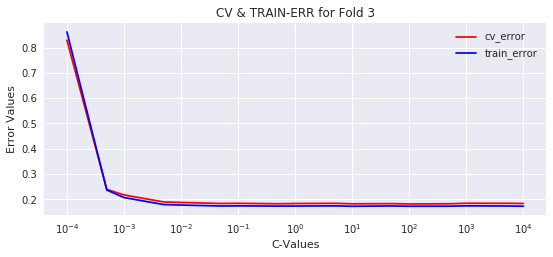

In [111]:
# cv error and test error for L1 regularization 
error_comparision(cv_l1_wv, train_l1_wv)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value near to 0.1.

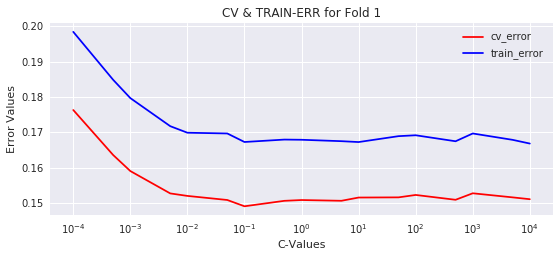

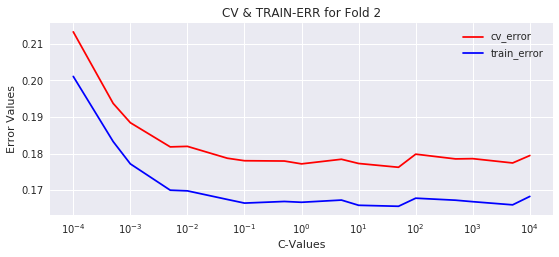

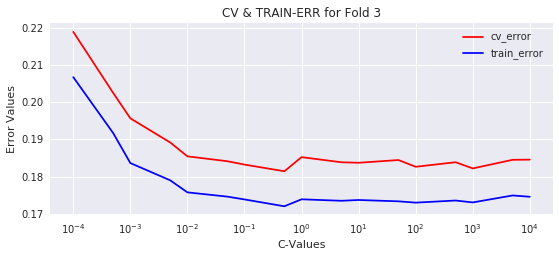

In [112]:
# cv error and test error for L2 regularization 
error_comparision(cv_l2_wv, train_l2_wv)

#### Observation:
* From these error plots for L2-Logistic Regression we get optimal error for C-value near to 0.1.

In [113]:
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=8)
train_vect = avg_w2v(train_x, w2v_model)
test_vect = avg_w2v(test_x, w2v_model)

### [C.] Grid Search 

In [122]:
pd.DataFrame(train_vect).min().min()

-4.2280042966206866

In [114]:
# finding best fit C using grid search(L1) 
grid_search_cv(train_vect, train_y, test_vect, test_y, 'l1')

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=8, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# finding best fit C using grid search(L2)
grid_search_cv(train_vect, train_y, test_vect, test_y, 'l2')

#### Observation:
* From grid-search we are getting optimal C equal to 5000 for L1 Logistic Regression and the accuracy is 84.4%.
* From grid-search we are getting optimal C equal to 500 for L2 Logistic Regression and the accuracy is equal to the L1 accuracy score.

### [D.] Random Search 

In [ ]:
# finding best fit λ using random search 
random_search_cv(train_vect, train_y, test_vect, test_y, 'l1')

In [ ]:
# finding best fit λ using random search 
random_search_cv(train_vect, train_y, test_vect, test_y, 'l2')

#### Observation:
* From random-search we are getting optimal C equal to 10 for L1 Logistic Regression and the accuracy is 84.4%.
* From random-search we are getting optimal C equal to 11.8 for L2 Logistic Regression and the accuracy is equal to the L1 accuracy score.

### [E.] Accuracy Matrics 


Test accuracy for C = '10' is '84.58530321601587'


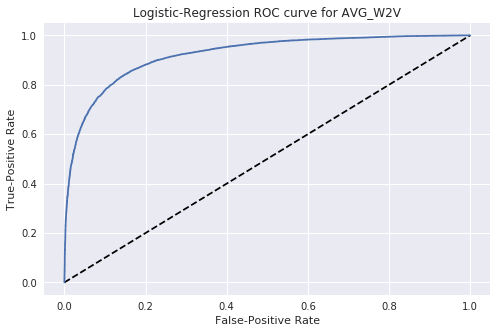

Area under the ROC curve is  0.9212473124630204

Confusion Matrix :
 [[14736  2507]
 [ 2775 14248]]

Normalized Confusion Matrix :
 [[0.85460767 0.14539233]
 [0.16301474 0.83698526]]


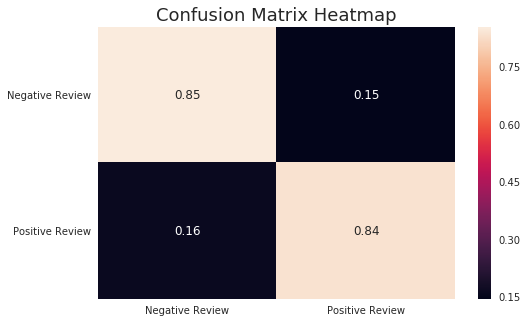

In [166]:
final_test_acc(avg_word2vec, score, 'l1', 10, 'AVG_W2V')

#### Observation:
* For L1 Logistic regression I choosed C to be 10 from random-search and we got here accuracy equal to 84.6% for test-set.
* Area under the ROC curve is 0.97 and false positive and false negative rates are also reasonable which is good.


Test accuracy for C = '12' is '84.58822156073076'


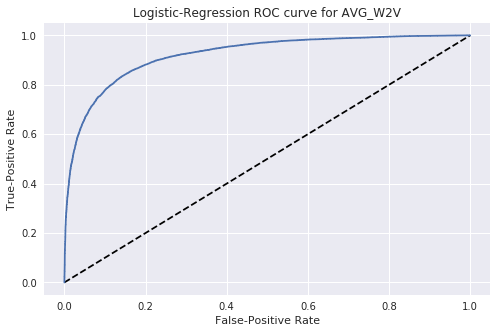

Area under the ROC curve is  0.9212512269161861

Confusion Matrix :
 [[14735  2508]
 [ 2773 14250]]

Normalized Confusion Matrix :
 [[0.85454967 0.14545033]
 [0.16289726 0.83710274]]


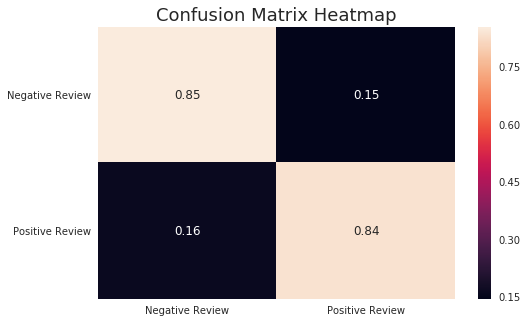

In [167]:
final_test_acc(avg_word2vec, score, 'l2', 12, 'AVG_W2V')

#### Observation:
* For L2 Logistic regression I choosed C to be 12 from random-search and we got here accuracy equal to 84.6% for test-set.
* Area under the ROC curve is 0.92 and false positive and false negative rates are also reasonable which is good.

### 9.1 TF-IDF weighted Word2Vec

In [32]:
# Determining TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() 

tfidf_sent_vectors = []
row = 0
for sent in list_of_sent[:10000]: 
    sent_vec = np.zeros(100)
    weight_sum = 0 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [45]:
tfidf_word2vec = np.matrix(tfidf_sent_vectors)

In [47]:
tfidf_word2vec.shape

(10000, 100)

### [A.] Both L1 and L2 Normalized Logistic Regression

In [57]:
# applying L1 & L2 Logistic Regression
cv_l1_tfidf_w2v, test_l1_tfidf_w2v, cv_l2_tfidf_w2v, test_l2_tfidf_w2v, w_nonz = logistic_regression(tfidf_word2vec, score[:10000])

In [58]:
cv_l1_tfidf_wv = np.reshape(cv_l1_tfidf_w2v,(3, 17))
test_l1_tfidf_wv = np.reshape(test_l1_tfidf_w2v,(3, 17))
cv_l2_tfidf_wv = np.reshape(cv_l2_tfidf_w2v,(3, 17))
test_l2_tfidf_wv = np.reshape(test_l2_tfidf_w2v,(3, 17))

In [59]:
# checking sparsity over different C for L1
c_val = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0,1000.0,5000.0,10000.0]
print("Number of non-zero weights for different values of C(1/λ) are:\n")
for i in range(len(c_val)):
    print("C = {:10.4f}      λ = {:10.4f}      nonzero_w = {:9.0f}".format(c_val[i],1/c_val[i],np.reshape(w_nonz,(3,17))[0,:][i]))

Number of non-zero weights for different values of C(1/λ) are:

C =     0.0001      λ = 10000.0000      nonzero_w =         0
C =     0.0005      λ =  2000.0000      nonzero_w =         0
C =     0.0010      λ =  1000.0000      nonzero_w =         0
C =     0.0050      λ =   200.0000      nonzero_w =         7
C =     0.0100      λ =   100.0000      nonzero_w =        16
C =     0.0500      λ =    20.0000      nonzero_w =        53
C =     0.1000      λ =    10.0000      nonzero_w =        74
C =     0.5000      λ =     2.0000      nonzero_w =        91
C =     1.0000      λ =     1.0000      nonzero_w =        94
C =     5.0000      λ =     0.2000      nonzero_w =        98
C =    10.0000      λ =     0.1000      nonzero_w =        99
C =    50.0000      λ =     0.0200      nonzero_w =       100
C =   100.0000      λ =     0.0100      nonzero_w =       100
C =   500.0000      λ =     0.0020      nonzero_w =       100
C =  1000.0000      λ =     0.0010      nonzero_w =       100
C =  5

#### Observation:
* We can see here as the λ value increases the non-zero weights count decreases i.e the weight vector becomes more sparse in case of L1 normalized Logistic Regression.

### [B.] Error Plot Over Different Values of Hyperparameter C (1 / λ)

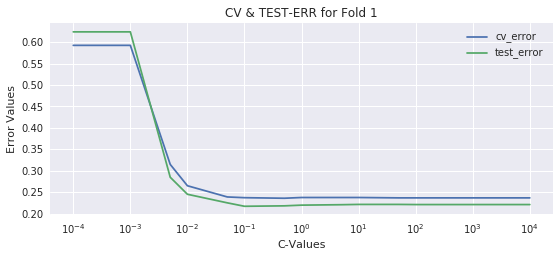

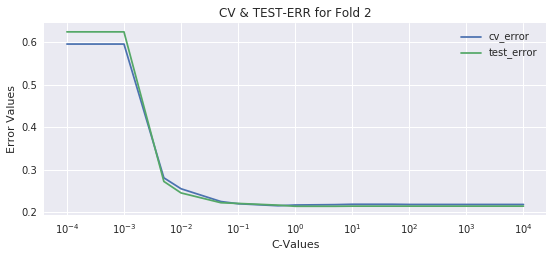

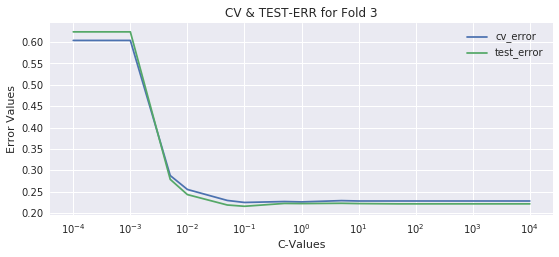

In [60]:
# cv error and test error for L1 regularization 
error_comparision(cv_l1_tfidf_wv, test_l1_tfidf_wv)

#### Observation:
* From these error plots for L1-Logistic Regression we get optimal error for C-value near to 0.1.

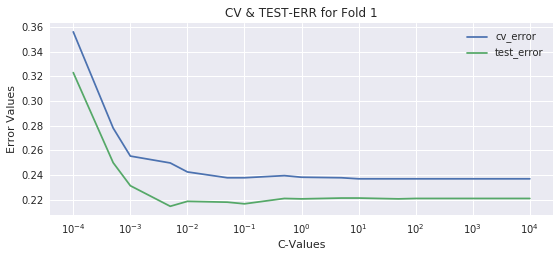

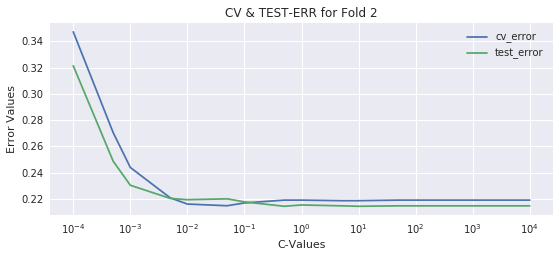

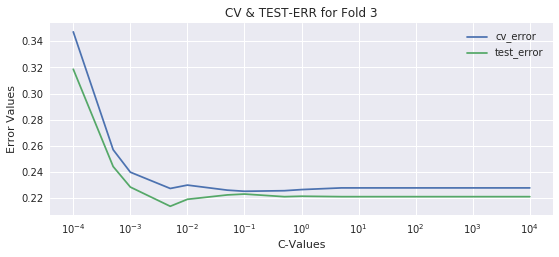

In [61]:
# cv error and test error for L2 regularization 
error_comparision(cv_l2_tfidf_wv, test_l2_tfidf_wv)

#### Observation:
* From these error plots for L2-Logistic Regression we get optimal error for C-value near to 0.01.

### [C.] Grid Search 

In [62]:
# finding best fit C using grid search(L1) 
grid_search_cv(tfidf_word2vec, score[:10000], 'l1')

LogisticRegression(C=50.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8296023176191731


In [63]:
# finding best fit C using grid search(L2)
grid_search_cv(tfidf_word2vec, score[:10000], 'l2')

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8343717549325025


#### Observation:
* From grid-search we are getting optimal C equal to 50 for L1 Logistic Regression and the accuracy is 83%.
* From grid-search we are getting optimal C equal to 0.01 for L2 Logistic Regression and the accuracy is nearly equal(83.4%) to the L1 accuracy score.

### [D.] Random Search 

In [64]:
# finding best fit C using random search(L1)
random_search_cv(tfidf_word2vec, score[:10000], 'l1')

LogisticRegression(C=9.295713802679954, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8296920242168992


In [65]:
# finding best fit C using random search(L2)
random_search_cv(tfidf_word2vec, score[:10000], 'l2')

LogisticRegression(C=9.782472739936987, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8296023176191731


#### Observation:
* From random-search we are getting optimal C equal to 9.3 for L1 Logistic Regression and the accuracy is 83%.
* From random-search we are getting optimal C equal to 9.8 for L2 Logistic Regression and the accuracy is equal to the L1 accuracy score.

### [E.] Accuracy Matrics 


Test accuracy for C = '9.3' is '78.43333333333334'


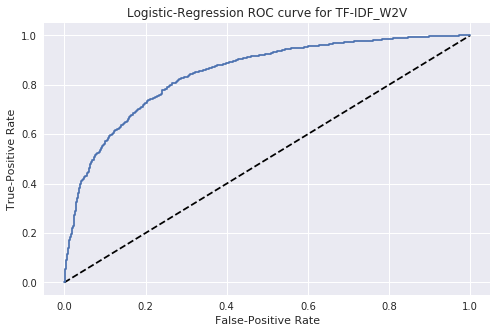

Area under the ROC curve is  0.845677433775838

Confusion Matrix :
 [[ 777  351]
 [ 296 1576]]

Normalized Confusion Matrix :
 [[0.68882979 0.31117021]
 [0.15811966 0.84188034]]


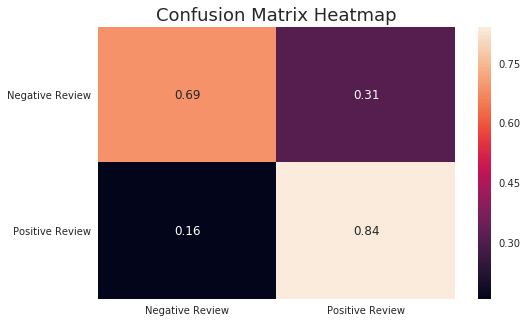

In [72]:
final_test_acc(tfidf_word2vec, score[:10000], 'l1', 9.3, 'TF-IDF_W2V')

#### Observation:
* For L1 Logistic regression I choosed C to be 9.8 from random-search and we got here accuracy equal to 78.4% for test-set which is ok but not that good.
* Area under the ROC curve is 0.84 but false negative rate is high, that means for TF-IDF weighted word2vec representation our model becomes little biased towards positive class which is not good.


Test accuracy for C = '0.01' is '78.73333333333333'


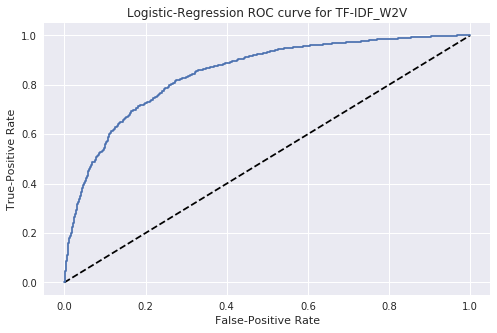

Area under the ROC curve is  0.8464081537552283

Confusion Matrix :
 [[ 755  373]
 [ 265 1607]]

Normalized Confusion Matrix :
 [[0.66932624 0.33067376]
 [0.14155983 0.85844017]]


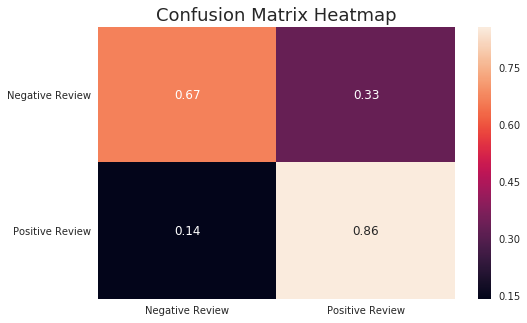

In [73]:
final_test_acc(tfidf_word2vec, score[:10000], 'l2', 0.01, 'TF-IDF_W2V')

#### Observation:
* For L2 Logistic regression I choosed C to be 0.01 from grid-search and we got here accuracy equal to 78.8%.
* Area under the ROC curve is 0.84 but again false negative rate is high, that means for TF-IDF weighted word2vec representation our model becomes little biased towards positive class which is bad.

## 10. Conclusion:
* Both Bag of Words(Bi-Gram) and TF-IDF representaion worked well here for Logistic Regression.
* The highest accuracy obtained by our model is 90.8% for TF-IDF representaion.
* Both Avg. Word2Vec and TF-IDF weighted Word2Vec did not perform well as they produced more over biased output towards positive class.